# Exercise 2: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw2_123456789_987654321.ipynb` if you submitted in pairs and `hw2_123456789.ipynb` if you submitted the exercise alone.
1. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
1. Write your functions in this notebook only. **Do not create Python modules and import them**.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
1. Your code must run without errors. Make sure your `numpy` version is at least 1.15.4 and that you are using at least python 3.6. Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

# I have read and understood the instructions: 205634272, 322698010

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in Java.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [2]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [3]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x7f839899a460>, <__main__.Node at 0x7f839899a790>]

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [4]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [30]:
data.isnull().any()

cap-shape                   False
cap-surface                 False
cap-color                   False
bruises                     False
odor                        False
gill-attachment             False
gill-spacing                False
gill-size                   False
gill-color                  False
stalk-shape                 False
stalk-surface-above-ring    False
stalk-surface-below-ring    False
stalk-color-above-ring      False
stalk-color-below-ring      False
veil-type                   False
veil-color                  False
ring-number                 False
ring-type                   False
spore-print-color           False
population                  False
habitat                     False
class                       False
dtype: bool

In [32]:
#############################################################################
# TODO: Find columns with missing values and remove them from the data.#
#############################################################################
# We have none but just so we can use this code for other applications
data.dropna(axis='columns',inplace=True)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

We will split the dataset to `Training` and `Testing` datasets.

In [33]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [34]:
# Evaluate the data
l = X[:,-1]
print(l)
u, cnt = np.unique(l,return_counts=True)
print(u)
print(cnt)
p=np.array(cnt)/len(l)
print(p)
np.sum(p*(1-p))
len(p.shape)
np.concatenate((np.array([0,1]),np.array([2,3])))

['p' 'e' 'e' ... 'e' 'p' 'p']
['e' 'p']
[4182 3942]
[0.51477105 0.48522895]


array([0, 1, 2, 3])

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

I have provided two methods below, both work

In [63]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    gini = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    if len(data.shape) == 1: labels = data # allow passing labels as numpy array, mostly for testing
    else: labels = data[:,-1] # otherwise, if it is a 2d array, then take the last column
    n_obs = len(labels) # total number of observations
    unique_labels, counts = np.unique(labels, return_counts=True) # count frequencies of unique labels
    probs = np.array(counts)/n_obs # empirical probabilities (normalized frequencies) of the labels
    gini = np.sum( probs*(1-probs) ) # compute gini as p1*(1-p1)+p2*(1-p2)+...
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return gini

In [64]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    entropy = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################

    if len(data.shape) == 1: labels = data # same as in calc_gini: purely for testing
    else: labels = data[:,-1] # if it is indeed a 2d array, then take the last column

    # same as before: compute empirical probabilities of each class:
    n_obs = len(labels) # total number of observations
    unique_labels, counts = np.unique(labels, return_counts=True) # count frequencies of unique labels
    probs = np.array(counts)/n_obs # empirical probabilities (normalized frequencies) of the labels
    
    # now just use the entropy formula:
    
    entropy = np.sum( -probs*np.log2(probs) )
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return entropy

In [65]:
##### Your Tests Here #####
#calc_gini(X), calc_entropy(X)

print("---------------Gini------------------")
print("Pure class: ",calc_gini(np.ones(20)))
print("50/50 mix of 2 classes: ",calc_gini(np.concatenate((np.ones(20),np.zeros(20)))))
print("10/90 mix of 2 classes: ",calc_gini(np.concatenate((np.ones(10),np.zeros(90)))))
print("Equal mix of 3 classes: ",calc_gini(np.concatenate((np.ones(20),np.zeros(20),np.ones(20)+1))))
print("Dataset X: ",calc_gini(X))

print("\n---------------Entropy---------------")
print("Pure class: ",calc_entropy(np.ones(20)))
print("50/50 mix of 2 classes: ",calc_entropy(np.concatenate((np.ones(20),np.zeros(20)))))
print("10/90 mix of 2 classes: ",calc_entropy(np.concatenate((np.ones(10),np.zeros(90)))))
print("Equal mix of 3 classes: ",calc_entropy(np.concatenate((np.ones(20),np.zeros(20),np.ones(20)+1))))
print("Dataset X: ",calc_entropy(X))


---------------Gini------------------
Pure class:  0.0
50/50 mix of 2 classes:  0.5
10/90 mix of 2 classes:  0.18
Equal mix of 3 classes:  0.6666666666666667
Dataset X:  0.4995636322379775

---------------Entropy---------------
Pure class:  0.0
50/50 mix of 2 classes:  1.0
10/90 mix of 2 classes:  0.4689955935892812
Equal mix of 3 classes:  1.584962500721156
Dataset X:  0.9993703627906085


In [37]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    gini = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    gini = np.power(np.unique(data[:,-1], return_counts=True)[1] / len(data), 2)    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return 1.0 - np.sum(gini)

In [40]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    entropy = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    probabilities = np.unique(data[:,-1], return_counts=True)[1] / len(data)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return -np.sum(probabilities * np.log2(probabilities))

In [42]:
##### Your Tests Here #####
equal_distribution = np.ones(100).reshape(10,10)
unequal_distribution = np.arange(100).reshape(10,10)

print("Gini, Entropy")
print("Equal distributions:")
print(calc_gini(equal_distribution), calc_entropy(equal_distribution))

print("Unequal distributions:")
print(calc_gini(unequal_distribution), calc_entropy(unequal_distribution))

print("Dataset:")
print(calc_gini(X), calc_entropy(X))

gini,entropy
Equal distributions:
0.0 -0.0
Unequal distributions:
0.8999999999999999 3.321928094887362
Dataset:
0.4995636322379775 0.9993703627906085


## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio as learned in class. You'll control the return value with the `gain_ratio` parameter. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). (10 Points)

In [43]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration).  
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    
    n_obs = data.shape[0] # number of observations
    var = data[:,feature] # variable to split on (here we just extract the actual array of values given the index)  
    unique_vals, counts = np.unique(var, return_counts = True) # values available in the feature, with their counts
    val_weights = np.array(counts) / n_obs # weights (probabilities) of different uniqe values in the specified feature
    
    goodness = impurity_func(data) # the first term; we will subtract the weighted impurities of the leaves below:
    
    # since below we are going to build a split anyway, shy don't we save an return it just in case;
    # the caller will just discard it if it is not good enough...
    split = {} 
    
    for u_val, weight in zip(unique_vals, val_weights):
        # get the subset of data where all values of the feature are equal to 'val' (i.e. a component of the split)
        data_leaf = data[ var==u_val,: ]
        leaf_impurity = impurity_func( data_leaf) 
        goodness -= weight*leaf_impurity
        split[u_val] = data_leaf
    
    if gain_ratio:
        # ok, now we need to calculate the split in information:
        split_info = np.sum( - val_weights * np.log2(val_weights) )
        # ... and normalize the entropy gain to it:
        goodness /= split_info
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return goodness, split    

In [44]:
# Test cell
[goodness_of_split(X_train, f, calc_gini)[0] for f in range(X_train.shape[1]-1)]
np.argmax([0,1,1,0.5])

1

## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class. (30 points)

In [45]:
class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    def __init__(self, feature, value=None, pred = None, counts = None):
        self.feature = feature # column index of criteria being tested
        self.children = []
        self.split_value = value # the value of the *parent node's* feature split which brings us to this node
        self.pred = pred # what do we predict for this node? Can be (but doesn't have to be) None for non-leaf nodes.
        self.counts = counts # counts for each of the examples in the node
        
    def add_child(self, node):
        self.children.append(node)
        
    def __str__(self):
        return "("+("<None>" if self.split_value is None else str(self.split_value) )+ \
                  ": " + str(self.pred)+ (" [LEAF]" if len(self.children)==0 else (" [Feature: "+str(self.feature)+", "+ str(len(self.children))+ " children]"))+")" 
    
    def __repr__(self): return self.__str__()

In [46]:
def build_tree(data, impurity, gain_ratio=False, min_samples_split=1, max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - min_samples_split: the minimum number of samples required to split an internal node
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    root = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    
    # label counts for the current node
    cnt_tuple = (unique_labels, counts) = np.unique(data[:,-1], return_counts = True)
    node_pred = unique_labels[ np.argmax(counts) ] # what should we predict for this node
    root = DecisionNode(None, pred=node_pred, counts=cnt_tuple) # set feature to None for now, as this node might end up being a leaf!
    
    if max_depth < 1: return root   # reached maximum depth, can't split anymore 
    if data.shape[0] < min_samples_split: return root # the node is too small, can't split anymore
    if len(unique_labels) == 1: return root # the node is pure, nothing to split (we would get it from the gain too, but why bother...)!!

    # OK, looks like we should try further splitting, let's do it:
    best_gain = 0
    best_feature = None
    best_split = None
    for feature in range(data.shape[1]-1): # try every feature (the last column is the outcome!)
        gain, split = goodness_of_split(data, feature, impurity, gain_ratio)
        if gain > best_gain:
            best_gain = gain
            best_feature = feature
            best_split = split
    
    if best_gain <= 1e-16: return root # no split results in any gain, give up...

    # save the feature the current node has to be split on for the best result:
    root.feature = best_feature

    # let us now recursively split the children and save them.
    # Note that if further split of a child is impossible, our build_tree function will still return 
    # that child as a node (with no children of course and with feature set to None)
    for (value, data_slice) in best_split.items():
        child_node = build_tree(data_slice, impurity, gain_ratio, min_samples_split, max_depth-1)
        child_node.split_value = value
        root.add_child(child_node)
      
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return root

In [47]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

## Tree evaluation

Complete the functions `predict` and `calc_accuracy`. (10 points)

In [48]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    
    f = node.feature
    if f is None:
        # we are at the leaf node, there are no more splits. Just predict
        # according to what this node says:
        return node.pred
    
    # the node prescribes to take a split on feature f. Let us get the value of that
    # feature in the instance we are working with:
    
    val = instance[f]
    
    # now let us find the child node that corresponds to that value:
    child = None
    for ch in node.children:
        if ch.split_value == val:
            # gotcha!
            child = ch
            break
    if child is None:
        # oops, we did bot have any examples for this combination of feature values
        # in the training set. Let us predict using the current node we were able to descend to:
        return node.pred
        #raise RuntimeError("Feature "+ str(f)+": instance value is "+str(val)+", not found in the tree! [Node="+str(node)+"]")
    
    # use the child node for prediction:
    pred = predict(child, instance)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return pred

In [49]:
# A quick test:
for i in range(10):
    print(X_train[i,:]," --> ",
        predict(tree_entropy_gain_ratio, X_train[i,:]))

['x' 's' 'y' 't' 'l' 'f' 'c' 'b' 'w' 'e' 's' 's' 'w' 'w' 'p' 'w' 'o' 'p'
 'n' 'n' 'g' 'e']  -->  e
['k' 'y' 'e' 'f' 'y' 'f' 'c' 'n' 'b' 't' 's' 'k' 'p' 'w' 'p' 'w' 'o' 'e'
 'w' 'v' 'l' 'e']  -->  e
['f' 'y' 'n' 'f' 's' 'f' 'c' 'n' 'b' 't' 's' 'k' 'w' 'p' 'p' 'w' 'o' 'e'
 'w' 'v' 'p' 'p']  -->  p
['f' 'y' 'n' 't' 'a' 'f' 'c' 'b' 'n' 'e' 's' 'y' 'w' 'w' 'p' 'w' 'o' 'p'
 'k' 's' 'p' 'e']  -->  e
['x' 's' 'n' 'f' 'n' 'f' 'w' 'b' 'p' 't' 's' 's' 'w' 'w' 'p' 'w' 'o' 'e'
 'n' 'a' 'g' 'e']  -->  e
['f' 'f' 'y' 'f' 'f' 'f' 'c' 'b' 'p' 'e' 'k' 'k' 'p' 'n' 'p' 'w' 'o' 'l'
 'h' 'v' 'p' 'p']  -->  p
['k' 's' 'n' 'f' 'y' 'f' 'c' 'n' 'b' 't' 's' 's' 'p' 'w' 'p' 'w' 'o' 'e'
 'w' 'v' 'l' 'p']  -->  p
['x' 'f' 'w' 'f' 'n' 'f' 'w' 'b' 'p' 'e' 's' 'k' 'w' 'w' 'p' 'w' 't' 'p'
 'w' 'n' 'g' 'e']  -->  e
['k' 'y' 'n' 'f' 'y' 'f' 'c' 'n' 'b' 't' 's' 's' 'w' 'w' 'p' 'w' 'o' 'e'
 'w' 'v' 'd' 'p']  -->  p
['f' 's' 'e' 'f' 'f' 'f' 'c' 'n' 'b' 't' 'k' 'k' 'w' 'w' 'p' 'w' 'o' 'e'
 'w' 'v' 'p' 'e']  -->  e


In [50]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    correct = 0
    for row in range(dataset.shape[0]):
        instance = dataset[row, :]
        truth = instance[-1] # the actual, correct label
        pred = predict(node, instance)
        if pred == truth: correct += 1
    
    accuracy = correct*100/dataset.shape[0]
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return accuracy 

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [51]:
#### Your code here ####
print("---- Accuracies of the trees on the test set: ---------")
print("Gini: ",calc_accuracy(tree_gini, X_test))
print("Entropy: ",calc_accuracy(tree_entropy, X_test))
print("Entropy with gain ratio: ",calc_accuracy(tree_entropy_gain_ratio, X_test))

---- Accuracies of the trees on the test set: ---------
Gini:  77.5972427375677
Entropy:  77.30182176267849
Entropy with gain ratio:  78.58197932053176


## Depth pruning

(15 points)

Consider the following max_depth values: [1, 2, 3, 4, 5, 6, 7, 8]. For each value, construct a tree and prune it according to the max_depth value = don't let the tree to grow beyond this depth. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the max_depth. Mark the best result on the graph with red circle.

In [52]:
#### Your code here ####

max_depths = np.array(range(1,9))
accuracies_train = []
accuracies_test = []
for md in max_depths: 
    pruned_tree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, max_depth= md) # entropy with gain ratio
    accuracies_train.append(calc_accuracy(pruned_tree, X_train))
    accuracies_test.append(calc_accuracy(pruned_tree, X_test))
                      

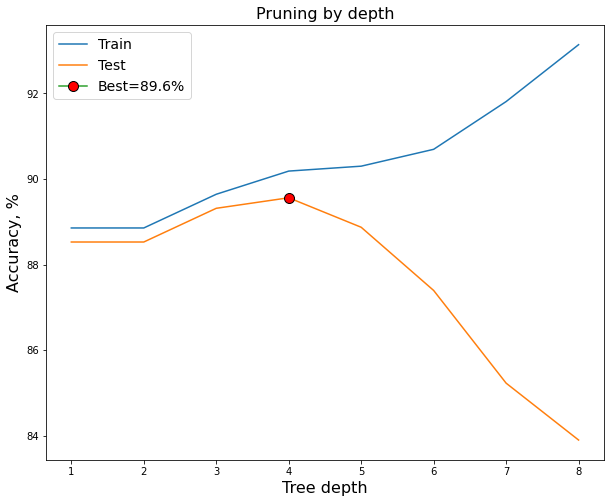

In [53]:
plt.plot(max_depths, accuracies_train, label="Train") 
plt.plot(max_depths, accuracies_test, label="Test") 

i=np.argmax(accuracies_test)
plt.plot(max_depths[i], accuracies_test[i], label="Best={0:.3}%".format(accuracies_test[i]), 
         marker='o', markersize=10, markerfacecolor='red', markeredgecolor='black') 

plt.legend(prop={'size':14})
plt.ylabel('Accuracy, %', size=16)
plt.xlabel('Tree depth', size=16)
plt.title("Pruning by depth", size=16)
plt.show()


## Min Samples Split

(15 points)

Consider the following min_samples_split values: [1, 5, 10, 20, 50]. For each value, construct a tree and prune it according to the min_samples_split value = don't split a node if the number of sample in it is less or equal to the min_samples_split value. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the min_samples_split. Mark the best result on the graph with red circle. (make sure that the x-axis ticks represent the values of min_samples_split)

In [54]:
#### Your code here ####
# essentially the same code as above, just this time we iterate over min_samples_split:

min_splits = np.array([1, 5, 10, 20, 50])
accuracies_train = []
accuracies_test = []
for ms in min_splits: 
    pruned_tree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split = ms) # entropy with gain ratio
    accuracies_train.append(calc_accuracy(pruned_tree, X_train))
    accuracies_test.append(calc_accuracy(pruned_tree, X_test))
                      


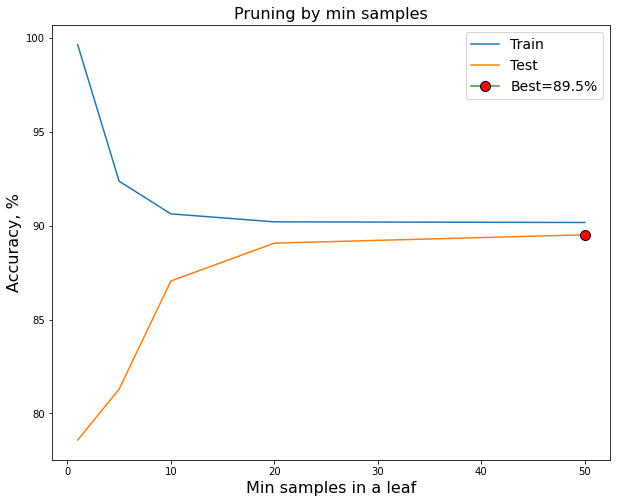

In [55]:
plt.plot(min_splits, accuracies_train, label="Train") 
plt.plot(min_splits, accuracies_test, label="Test") 

i=np.argmax(accuracies_test)
plt.plot(min_splits[i], accuracies_test[i], label="Best={0:.3}%".format(accuracies_test[i]), 
         marker='o', markersize=10, markerfacecolor='red', markeredgecolor='black') 

plt.legend(prop={'size':14})
plt.ylabel('Accuracy, %', size=16)
plt.xlabel('Min samples in a leaf', size=16)
plt.title("Pruning by min samples", size=16)
plt.show()


Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_min_samples_split - the best tree according to min_samples_split pruning

In [56]:
#### Your code here ####
tree_max_depth = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, max_depth= 4) 
tree_min_samples_split = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split = 50) # entropy with gain ratio

## Number of Nodes

(5 points)

Complete the function counts_nodes and print the number of nodes in each tree and print the number of nodes of the two trees above

In [57]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    n = 0
    # count nodes in the children (each child will return at least 1 if it has 
    # no children of its own:
    for ch in node.children:
        n+=count_nodes(ch)
    return n+1 # count the current node (that's what +1 is for) and return
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    

In [58]:
print("Max depth tree:", count_nodes(tree_max_depth), "nodes")
print("Min samples tree:", count_nodes(tree_min_samples_split), "nodes")

Max depth tree: 205 nodes
Min samples tree: 349 nodes


## Print the tree

Complete the function `print_tree`. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

(5 points)

In [59]:
# you can change the function signature
def print_tree(node, depth=0, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    print(" "*2*depth, end='')
    print("[X",parent_feature, end='', sep="")
    if feature_val != 'ROOT':
        print("=", feature_val,end='', sep="")
    if node.feature is None and len(node.children) > 0 or \
       node.feature is not None and len(node.children) == 0:
            raise RuntimeError("Inconsistent node: ", str(node))
    if node.feature is None: # it's a leaf!
        print(", leaf]: [{", end='')
        print(", ".join(["{0}: {1}".format(cls, cnt) for cls, cnt in zip(node.counts[0], node.counts[1])]), "}]", end="")
    else:
        print(", feature=X",node.feature,"]", end="", sep="")
    print()
    for ch in node.children:
        print_tree(ch, depth=depth+1, parent_feature=node.feature, feature_val=ch.split_value)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

print the tree with the best test accuracy and with less than 50 nodes (from the two pruning methods)

In [60]:
#### Your code here ####

# the best trees we found so far are too big (have > 50 nodes) - let's search again, this time for the best tree
# with the additional constraint of < 50 nodes:

max_depths = np.array(range(1,6))
acctest_depth = []
for md in max_depths: 
    ptree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, max_depth= md) # entropy with gain ratio
    if count_nodes(ptree) >=50: 
        acctest_depth.append(0) # oops, tree is too big
    else: 
        acctest_depth.append(calc_accuracy(ptree, X_test))

min_splits = np.array([50, 75, 100, 150, 200, 300, 350, 400, 450,  500])

acctest_split = []
for ms in min_splits: 
    ptree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split = ms) # entropy with gain ratio
    if count_nodes(ptree) >=50: 
        acctest_split.append(0) # oops, tree is too big
    else: 
        acctest_split.append(calc_accuracy(ptree, X_test))

i_d=np.argmax(acctest_depth)
i_s=np.argmax(acctest_split)
print("The best depth-pruned model with n < 50 nodes: MaxDepth=",max_depths[i_d],"; Test accuracy=",acctest_depth[i_d], sep='')        
print("The best min split size-pruned model with n < 50 nodes: MinSplitSize=",min_splits[i_s],"; Test accuracy=",acctest_split[i_s], sep='')        

# refit the best model
best_tree_n50 = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split = 450)

print("-----------------------------------------\nBest tree with n<50 nodes:\n-----------------------------------------")

print_tree(best_tree_n50)

The best depth-pruned model with n < 50 nodes: MaxDepth=1; Test accuracy=88.52781880846874
The best min split size-pruned model with n < 50 nodes: MinSplitSize=450; Test accuracy=89.31560807483999
-----------------------------------------
Best tree with n<50 nodes:
-----------------------------------------
[XROOT, feature=X4]
  [X4=a, leaf]: [{e: 273, p: 31 }]
  [X4=c, leaf]: [{e: 10, p: 137 }]
  [X4=f, feature=X10]
    [X10=f, leaf]: [{e: 14, p: 91 }]
    [X10=k, feature=X11]
      [X11=k, feature=X7]
        [X7=b, feature=X19]
          [X19=v, feature=X20]
            [X20=d, leaf]: [{e: 10, p: 144 }]
            [X20=g, leaf]: [{e: 18, p: 140 }]
            [X20=p, leaf]: [{e: 18, p: 139 }]
          [X19=y, feature=X2]
            [X2=g, leaf]: [{e: 27, p: 223 }]
            [X2=y, leaf]: [{e: 39, p: 208 }]
        [X7=n, leaf]: [{e: 6, p: 97 }]
      [X11=s, leaf]: [{e: 16, p: 86 }]
    [X10=s, leaf]: [{e: 22, p: 310 }]
  [X4=l, leaf]: [{e: 272, p: 27 }]
  [X4=m, leaf]: [{e: 2, 

In [62]:
# It appears an update was posted toward the end of submission on piazza 
# So per the update for max depth 1-8 and min splits 1,5,10,20,50 here is the output
# I finished a long time ago and so just updated the code with the values
# As you can see however, the test accuracy is consistent regardless

max_depths = np.array(range(1,9)) #[start,stop)
acctest_depth = []
for md in max_depths: 
    ptree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, max_depth= md) # entropy with gain ratio
    if count_nodes(ptree) >=50: 
        acctest_depth.append(0) # oops, tree is too big
    else: 
        acctest_depth.append(calc_accuracy(ptree, X_test))

min_splits = np.array([1,5,10,20,50])

acctest_split = []
for ms in min_splits: 
    ptree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split = ms) # entropy with gain ratio
    if count_nodes(ptree) >=50: 
        acctest_split.append(0) # oops, tree is too big
    else: 
        acctest_split.append(calc_accuracy(ptree, X_test))

i_d=np.argmax(acctest_depth)
i_s=np.argmax(acctest_split)
print("The best depth-pruned model with n < 50 nodes: MaxDepth=",max_depths[i_d],"; Test accuracy=",acctest_depth[i_d], sep='')        
print("The best min split size-pruned model with n < 50 nodes: MinSplitSize=",min_splits[i_s],"; Test accuracy=",acctest_split[i_s], sep='')        

# refit the best model
best_tree_n50 = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split = 450)

print("-----------------------------------------\nBest tree with n<50 nodes:\n-----------------------------------------")

print_tree(best_tree_n50)

The best depth-pruned model with n < 50 nodes: MaxDepth=1; Test accuracy=88.52781880846874
The best min split size-pruned model with n < 50 nodes: MinSplitSize=1; Test accuracy=0
-----------------------------------------
Best tree with n<50 nodes:
-----------------------------------------
[XROOT, feature=X4]
  [X4=a, leaf]: [{e: 273, p: 31 }]
  [X4=c, leaf]: [{e: 10, p: 137 }]
  [X4=f, feature=X10]
    [X10=f, leaf]: [{e: 14, p: 91 }]
    [X10=k, feature=X11]
      [X11=k, feature=X7]
        [X7=b, feature=X19]
          [X19=v, feature=X20]
            [X20=d, leaf]: [{e: 10, p: 144 }]
            [X20=g, leaf]: [{e: 18, p: 140 }]
            [X20=p, leaf]: [{e: 18, p: 139 }]
          [X19=y, feature=X2]
            [X2=g, leaf]: [{e: 27, p: 223 }]
            [X2=y, leaf]: [{e: 39, p: 208 }]
        [X7=n, leaf]: [{e: 6, p: 97 }]
      [X11=s, leaf]: [{e: 16, p: 86 }]
    [X10=s, leaf]: [{e: 22, p: 310 }]
  [X4=l, leaf]: [{e: 272, p: 27 }]
  [X4=m, leaf]: [{e: 2, p: 25 }]
  [X4=n, 